import library

In [1]:
!pip install pytorch-transformers
!pip install pytorch-pretrained-bert pytorch-nlp
!pip install pytorch_pretrained_bert
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

     |████████████████████████████████| 176 kB 5.3 MB/s 
     |████████████████████████████████| 895 kB 40.2 MB/s 
     |████████████████████████████████| 131 kB 50.6 MB/s 
     |████████████████████████████████| 1.2 MB 17.3 MB/s 
     |████████████████████████████████| 79 kB 8.1 MB/s 
     |████████████████████████████████| 7.9 MB 25.0 MB/s 
     |████████████████████████████████| 138 kB 48.8 MB/s 
     |████████████████████████████████| 127 kB 45.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 123 kB 6.7 MB/s 
     |████████████████████████████████| 90 kB 7.5 MB/s 


# Load twitter dataset  

In [46]:
pd.set_option('display.max_colwidth', None)
data = pd.read_excel("final_data.xlsx")
#data = data.sample(n = 100)
print('We have',len(data), 'tweet in the data')

We have 439 tweet in the data


In [47]:
data = data[['preprocess_tweets','object','emojis']]
data = data.dropna()
labels = data.emojis.values
print('We have',len(data), 'not nan tweet in the data')
#data.head(10)

We have 428 not nan tweet in the data


In [34]:
# number of sentense for each emoji
print(data['emojis'].value_counts())

2     13
0      9
8      8
1      7
18     6
4      6
6      5
7      5
12     5
19     4
10     4
15     4
16     4
9      4
13     3
14     3
11     2
5      2
3      2
17     2
Name: emojis, dtype: int64


# Train Topic Model (LDA)

In [51]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = CountVectorizer(analyzer='word',       
                             min_df=1,                         # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             max_features=1000,                # max number of uniq words
                            )

data_vectorized1 = vectorizer.fit_transform(data['preprocess_tweets'])
data_vectorized2 = vectorizer.fit_transform(data['object'])

In [52]:
print(data_vectorized1.shape)
print(data_vectorized2.shape)

(428, 1000)
(428, 1000)


In [53]:
from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(n_components=90,           # Number of topics
                                      learning_method='online',
                                      random_state=0,            # Random state
                                      n_jobs = -1                # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(np.concatenate((data_vectorized1.toarray(),data_vectorized2.toarray())))

In [54]:
def predict_topic(text):

    # Step 1: Vectorize transform
    mytext_4 = vectorizer.transform(text)

    # Step 2: LDA Transform
    topic_probability_scores = lda_model.transform(mytext_4)

    return topic_probability_scores

prob_scores_q1 = predict_topic(text = data['preprocess_tweets'])
print(prob_scores_q1.shape)
prob_scores_q2 = predict_topic(text = data['object'])
print(prob_scores_q2.shape)

(428, 90)
(428, 90)


# Preparing data to enter the BERT network

In [55]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# function to tokenize and generate input ids for the tokens
# returns a list of input ids
def prep_data(ques1, ques2):
    
  all_input_ids = []
  
  for (q1,q2) in zip(ques1, ques2):
    
    # first sentence is appended with [CLS] and [SEP] in the beginning and end
    q1 = '[CLS] ' + q1 + ' [SEP] '
    tokens = tokenizer.tokenize(q1)
    
    # 0 denotes first sentence
    seg_ids = [0] * len(tokens)
    
    # second sentence is appended with [SEP] in the end
    #print(q2.type)
    q2 = q2 + ' [SEP] '
    tok_q2 = tokenizer.tokenize(q2)
    
    # seg ids is appended with 1 to denote second sentence
    seg_ids += [1] * len(tok_q2)
    
    # first and second sentence tokens are appended together
    tokens += tok_q2
    
    # input ids are generated for the tokens (one question pair)
    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # input ids are stored in a separate list
    all_input_ids.append(input_ids)
    
  return all_input_ids

all_input_ids = prep_data(data['preprocess_tweets'].values, data['object'].values)

In [56]:
# pad sentence to have equal size 
max_len = 0
for i in all_input_ids: 
    if max_len < len(i):
        max_len = len(i)

# max len of sentences 
n = max_len
pad_input_ids = pad_sequences(all_input_ids, maxlen=n, dtype="long", truncating="post", padding="post")

In [57]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in pad_input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [20]:
# Function to calculate the accuracy of our predictions vs labels
def accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [22]:
import torch.nn as nn
import torch.nn.functional as F
from pytorch_pretrained_bert import  BertModel

    
class my_BERT(nn.Module):
    ''' A sequence to sequence model with attention mechanism. '''
    def __init__(self,emb_size, topic_num):
 
        super().__init__()
        self.tbert = BertModel.from_pretrained('bert-base-uncased')
        self.trg_word_prj = nn.Linear(emb_size + topic_num + topic_num, 20, bias=False)

    def forward(self, b_input_ids, attention_mask, topics, token_type_ids=None):
        
        _,pooled_layer = self.tbert(b_input_ids,attention_mask)
        out = self.trg_word_prj(torch.cat((pooled_layer,topics),-1))
        return  F.softmax(out)


In [14]:
emb_size = 768
topic_num = 90
model = my_BERT(emb_size,topic_num)
model.to(device)

100%|██████████| 407873900/407873900 [00:11<00:00, 36682325.69B/s]


my_BERT(
  (tbert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
          

In [58]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs,validation_inputs,train_labels,validation_labels=train_test_split(np.concatenate((pad_input_ids,prob_scores_q1,prob_scores_q2),axis=-1),labels,random_state=2018,test_size=0.2,)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, pad_input_ids,random_state=2018, test_size=0.2)

In [59]:
train_topics = torch.tensor(train_inputs[:,n:])
train_inputs = torch.tensor(train_inputs[:,0:n])

validation_topics = torch.tensor(validation_inputs[:,n:])
validation_inputs = torch.tensor(validation_inputs[:,0:n])

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [60]:
# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

batch_size = 2
train_data = TensorDataset(train_inputs, train_masks, train_labels,train_topics)
train_dataloader = DataLoader(train_data,batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels,validation_topics)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size)


In [26]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [27]:
import torch.nn as nn
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = BertAdam(optimizer_grouped_parameters,lr=2e-5,warmup=.1)

t_total value of -1 results in schedule not being applied


In [61]:
train_loss_set = []
train_acc_set = []


epochs = 20
from tqdm import trange 
from sklearn.metrics import f1_score


# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
    
  # Training 
  model.train()
  
  # Tracking variables
  tr_loss = 0
  train_accuracy = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_topics= batch
   
    # Clear out the gradients
    optimizer.zero_grad()
     
    ###############Bug fix code####################
    b_input_ids = b_input_ids.type(torch.LongTensor)
    b_input_mask = b_input_mask.type(torch.LongTensor)
    b_labels = b_labels.type(torch.LongTensor)
    b_input_ids = b_input_ids.to(device)
    b_input_mask = b_input_mask.to(device)
    b_labels = b_labels.to(device)
    ###############Bug fix code####################

    # Forward pass
    outputs = model(b_input_ids,b_input_mask,b_topics.float().to(device))
    loss = criterion(outputs, b_labels)
    train_loss_set.append(loss.item())    


    
    # Backward pass
    loss.backward()
    
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # train accuracy
    logitss = outputs.detach().cpu().numpy()
    label_idss = b_labels.detach().cpu().numpy()
    tmp_train_accuracy = accuracy(logitss, label_idss)
    train_acc_set.append(tmp_train_accuracy)    
    train_accuracy += tmp_train_accuracy

    # train accuracy
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps),
        "---train Accuracy: {}".format(train_accuracy/nb_tr_steps))
      
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy ,eval_f1= 0, 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_topics = batch
    
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      ###############Bug fix code####################
      b_input_ids = b_input_ids.type(torch.LongTensor)
      b_input_mask = b_input_mask.type(torch.LongTensor)
      b_input_ids = b_input_ids.to(device)
      b_input_mask = b_input_mask.to(device)
      ###############Bug fix code####################
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids,b_input_mask,b_topics.float().to(device))
    
    # Move logits and labels to CPU
    losss = criterion(logits, b_labels)
    eval_loss += losss.item()
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.detach().cpu().numpy()
    tmp_eval_accuracy = accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    ftat_digit = np.argmax(logits, axis=1).flatten()
    tmp_eval_f1= f1_score(ftat_digit, label_ids, average="micro" )
    eval_f1 += tmp_eval_f1
    nb_eval_steps += 1

  print("Validation loss: {}".format(eval_loss/nb_eval_steps),
        "---Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps),
        "----valdisation F1 score:{}".format(eval_f1/nb_eval_steps))

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Train loss: 2.966718786641171 ---train Accuracy: 0.08771929824561403


Epoch:   5%|▌         | 1/20 [01:06<21:11, 66.90s/it]

Validation loss: 2.9693891336751537 ---Validation Accuracy: 0.10465116279069768 ----valdisation F1 score:0.10465116279069768
Train loss: 2.96245771402504 ---train Accuracy: 0.09941520467836257


Epoch:  10%|█         | 2/20 [02:13<20:00, 66.71s/it]

Validation loss: 2.9694983903751817 ---Validation Accuracy: 0.10465116279069768 ----valdisation F1 score:0.10465116279069768
Train loss: 2.961652992761623 ---train Accuracy: 0.09064327485380116


Epoch:  15%|█▌        | 3/20 [03:20<18:53, 66.65s/it]

Validation loss: 2.969108736792276 ---Validation Accuracy: 0.10465116279069768 ----valdisation F1 score:0.10465116279069768
Train loss: 2.960423511371278 ---train Accuracy: 0.1023391812865497


Epoch:  20%|██        | 4/20 [04:26<17:46, 66.67s/it]

Validation loss: 2.9696086783741795 ---Validation Accuracy: 0.10465116279069768 ----valdisation F1 score:0.10465116279069768
Train loss: 2.960533082136634 ---train Accuracy: 0.09649122807017543


Epoch:  25%|██▌       | 5/20 [05:33<16:40, 66.67s/it]

Validation loss: 2.968119321867477 ---Validation Accuracy: 0.10465116279069768 ----valdisation F1 score:0.10465116279069768
Train loss: 2.9616108456550285 ---train Accuracy: 0.09649122807017543


Epoch:  30%|███       | 6/20 [06:40<15:33, 66.70s/it]

Validation loss: 2.9695951716844426 ---Validation Accuracy: 0.10465116279069768 ----valdisation F1 score:0.10465116279069768
Train loss: 2.9599818416506225 ---train Accuracy: 0.09941520467836257


Epoch:  35%|███▌      | 7/20 [07:46<14:27, 66.73s/it]

Validation loss: 2.969505237978558 ---Validation Accuracy: 0.10465116279069768 ----valdisation F1 score:0.10465116279069768
Train loss: 2.959172975250155 ---train Accuracy: 0.0935672514619883


Epoch:  40%|████      | 8/20 [08:53<13:20, 66.69s/it]

Validation loss: 2.9668157821477847 ---Validation Accuracy: 0.10465116279069768 ----valdisation F1 score:0.10465116279069768
Train loss: 2.962558038053457 ---train Accuracy: 0.09941520467836257


Epoch:  45%|████▌     | 9/20 [10:00<12:13, 66.68s/it]

Validation loss: 2.9699644099834352 ---Validation Accuracy: 0.10465116279069768 ----valdisation F1 score:0.10465116279069768
Train loss: 2.958747018847549 ---train Accuracy: 0.1111111111111111


Epoch:  50%|█████     | 10/20 [11:06<11:05, 66.58s/it]

Validation loss: 2.970465992772302 ---Validation Accuracy: 0.10465116279069768 ----valdisation F1 score:0.10465116279069768
Train loss: 2.958270848145959 ---train Accuracy: 0.1023391812865497


Epoch:  55%|█████▌    | 11/20 [12:13<09:59, 66.62s/it]

Validation loss: 2.969667129738386 ---Validation Accuracy: 0.10465116279069768 ----valdisation F1 score:0.10465116279069768
Train loss: 2.9586363535875466 ---train Accuracy: 0.10526315789473684


Epoch:  60%|██████    | 12/20 [13:20<08:53, 66.68s/it]

Validation loss: 2.9698661427165187 ---Validation Accuracy: 0.10465116279069768 ----valdisation F1 score:0.10465116279069768
Train loss: 2.9603535292441383 ---train Accuracy: 0.1023391812865497


Epoch:  65%|██████▌   | 13/20 [14:26<07:46, 66.71s/it]

Validation loss: 2.9689720120540883 ---Validation Accuracy: 0.10465116279069768 ----valdisation F1 score:0.10465116279069768
Train loss: 2.9578690821664377 ---train Accuracy: 0.10818713450292397


Epoch:  70%|███████   | 14/20 [15:33<06:40, 66.78s/it]

Validation loss: 2.9689606677654177 ---Validation Accuracy: 0.10465116279069768 ----valdisation F1 score:0.10465116279069768
Train loss: 2.9598494663573147 ---train Accuracy: 0.09941520467836257


Epoch:  75%|███████▌  | 15/20 [16:40<05:34, 66.85s/it]

Validation loss: 2.9693539419839547 ---Validation Accuracy: 0.10465116279069768 ----valdisation F1 score:0.10465116279069768
Train loss: 2.9597708049573397 ---train Accuracy: 0.10818713450292397


Epoch:  80%|████████  | 16/20 [17:47<04:27, 66.86s/it]

Validation loss: 2.9699646539466324 ---Validation Accuracy: 0.10465116279069768 ----valdisation F1 score:0.10465116279069768
Train loss: 2.9591374383335225 ---train Accuracy: 0.09064327485380116


Epoch:  85%|████████▌ | 17/20 [18:54<03:20, 66.88s/it]

Validation loss: 2.969890211903772 ---Validation Accuracy: 0.10465116279069768 ----valdisation F1 score:0.10465116279069768
Train loss: 2.959292765946416 ---train Accuracy: 0.09649122807017543


Epoch:  90%|█████████ | 18/20 [20:01<02:13, 66.90s/it]

Validation loss: 2.9698125262593114 ---Validation Accuracy: 0.10465116279069768 ----valdisation F1 score:0.10465116279069768
Train loss: 2.960267536821421 ---train Accuracy: 0.09649122807017543


Epoch:  95%|█████████▌| 19/20 [21:08<01:06, 66.99s/it]

Validation loss: 2.9705634006234103 ---Validation Accuracy: 0.10465116279069768 ----valdisation F1 score:0.10465116279069768
Train loss: 2.959101313038876 ---train Accuracy: 0.09649122807017543


Epoch: 100%|██████████| 20/20 [22:15<00:00, 66.79s/it]

Validation loss: 2.9702373327210894 ---Validation Accuracy: 0.10465116279069768 ----valdisation F1 score:0.10465116279069768


Text(0.5, 1.0, 'Train-loss')

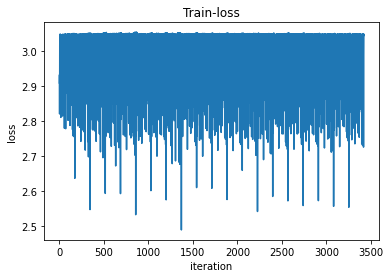

In [64]:
import matplotlib.pyplot as plt
plt.plot(train_loss_set)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Train-loss')

Text(0.5, 1.0, 'Train-accuracy')

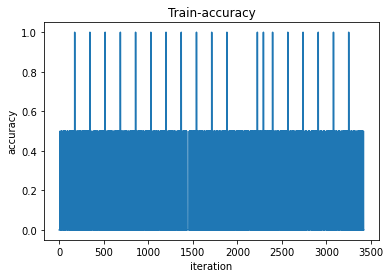

In [65]:
plt.plot(train_acc_set)
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('Train-accuracy')